# 07 Inferencia y Evaluación del Modelo

Este notebook se centra en la etapa de inferencia, donde el modelo previamente entrenado para la detección de balsas en imágenes aéreas se aplica a una nueva imagen para realizar predicciones. Además, se explora la conversión de estas predicciones en geometrías georreferenciadas para su posterior análisis espacial. Se destaca el uso de la librería SAHI (Slicing Aided Hyper Inference) para optimizar la inferencia en imágenes de gran tamaño.

**Objetivo**: Validar el modelo final y asegurar que no hay overfitting.

**Contenido**:

* Inferencia con SAHI.
* Análisis de las Predicciones.
* Conversión de Predicciones a Geometrías Georreferenciadas.
* Visualización de los Resultados Georreferenciados (Qgis).


**Porque Utilizar SAHI en la Inferencia?:**

La librería **SAHI** (Slicing Aided Hyper Inference) ofrece varias ventajas significativas al realizar inferencia con modelos de detección de objetos, especialmente en el contexto de imágenes aéreas de alta resolución:

1.  **Manejo eficiente de imágenes de gran tamaño:** Las imágenes aéreas suelen tener dimensiones muy grandes, lo que puede generar problemas de memoria (Out of Memory - OOM) al intentar procesarlas completas con un modelo de detección. SAHI resuelve este problema dividiendo la imagen grande en **"slices" o ventanas más pequeñas**. Estas slices se procesan de forma individual, lo que reduce drásticamente el consumo de memoria y permite realizar inferencia en imágenes que de otra manera serían inaccesibles.

2.  **Mejora en la detección de objetos pequeños:** Al realizar la inferencia en slices, cada objeto tiene una mayor probabilidad de ocupar una porción significativa de la ventana de entrada del modelo. Esto puede **mejorar la capacidad del modelo para detectar objetos pequeños** que podrían perderse o detectarse con baja confianza si se procesara la imagen completa a una escala reducida o si los objetos pequeños solo ocuparan unos pocos píxeles en la entrada del modelo.

3.  **Reducción de artefactos en los bordes:** Al utilizar un **solapamiento (overlap)** entre las slices adyacentes, SAHI asegura que los objetos que se encuentran en los bordes de las slices no se corten completamente y tengan la oportunidad de ser detectados por completo en al menos una de las slices. El posterior **postprocesamiento** (como GREEDYNMM con la métrica IOS - Intersection Over Smallest) se encarga de fusionar las predicciones redundantes de las diferentes slices para obtener un conjunto final de detecciones coherente para la imagen completa.

4.  **Flexibilidad en la configuración:** SAHI permite ajustar parámetros clave como el tamaño de las slices (`slice_height`, `slice_width`) y la cantidad de solapamiento (`overlap_height_ratio`, `overlap_width_ratio`). Esto proporciona flexibilidad para optimizar el proceso de inferencia según las características de las imágenes y los recursos computacionales disponibles.

**SAHI** es una herramienta poderosa que permite realizar inferencia de manera eficiente y, a menudo, con mayor precisión en imágenes de alta resolución al abordar las limitaciones de memoria y mejorar la detección de objetos de diferentes tamaños a través de una estrategia de procesamiento por partes y un inteligente postprocesamiento.

## Importamos librerias necesarias

*Se recomienda intalar Ultralitics en un entorno independiente*

In [1]:
# instalamos las librerias necesarias
#!pip install -U ultralytics sahi ipywidgets

In [2]:
# Importamos librerias necesarias
import os
from sahi.predict import get_sliced_prediction  # Predicciones en imágenes grandes dividiéndolas en ventanas más pequeñas.
from sahi import AutoDetectionModel  # Clase de SAHI para cargar modelos de detección de objetos preentrenados.
from sahi.utils.file import download_from_url
from sahi.utils.ultralytics import download_yolov8n_model
import rasterio
from shapely.geometry import Polygon
import geopandas as gpd
import pandas as pd
import random
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from pathlib import Path
from tqdm import tqdm

## Inferencia sobre las imagenes de test
Predicción Utilizando el Modelo Entrenado

Muestra de las prediciones de 8 imágenes aleatorias de la carpeta test. Cada vez que se ejecute el código se visualizaran nuesvas imágenges de las prediciones con su OBBs y % de confianza. 

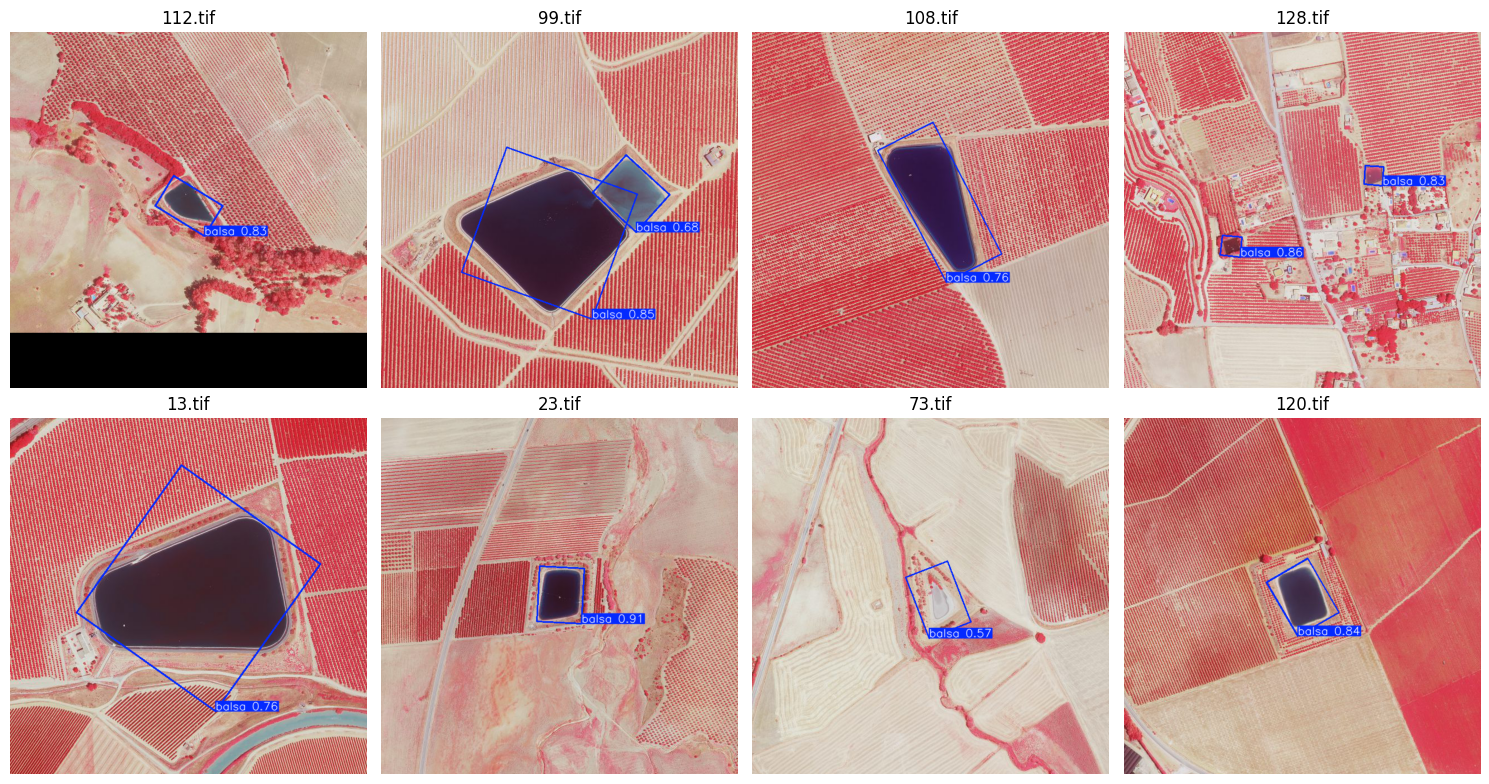

CPU times: user 3.77 s, sys: 338 ms, total: 4.11 s
Wall time: 1.74 s


In [3]:
%%time
def show_images_grid(image_paths, predictions, titles, rows=2, cols=4):
    """Función para mostrar múltiples imágenes en una cuadrícula."""
    fig, axes = plt.subplots(rows, cols, figsize=(15, 8))  # Ajustamos el tamaño de la figura
    axes = axes.flatten()  # Aplanar el array de ejes para facilitar el acceso
    
    for i, (img_path, pred_list, title) in enumerate(zip(image_paths, predictions, titles)):
        img = cv2.imread(img_path)  # Leer la imagen original
        
        # Acceder al primer elemento de la lista de resultados
        pred = pred_list[0]
        
        # Obtener la imagen con las predicciones dibujadas
        img_with_predictions = pred.plot()
        
        # Mostrar la imagen en el subplot correspondiente
        axes[i].imshow(cv2.cvtColor(img_with_predictions, cv2.COLOR_BGR2RGB))
        axes[i].set_title(title)  # Usar el nombre del archivo como título
        axes[i].axis("off")
    
    # Ocultar los subplots vacíos si hay menos imágenes que espacios en la cuadrícula
    for j in range(len(image_paths), len(axes)):
        axes[j].axis("off")
    
    plt.tight_layout()
    plt.show()

# Cargar el modelo entrenado
model = YOLO("../models/balsas_best.pt") 

# Ruta del directorio de imágenes de test
test_images_dir = "../data/processed/dataset/images/test/"

# Obtener una lista de todas las imágenes en el directorio de prueba
all_test_images = [os.path.join(test_images_dir, img) for img in os.listdir(test_images_dir) if img.endswith(('.jpg', '.jpeg', '.png', '.tif'))]

# Seleccionar 8 imágenes aleatorias
selected_images = random.sample(all_test_images, 8)

# Realizar inferencia con el modelo en las imágenes seleccionadas (sin mensajes verbales)
results = [model(img_path, verbose=False) for img_path in selected_images]  # Agregamos verbose=False

# Preparar títulos para cada imagen: usar los nombres de los archivos con extensión
titles = [os.path.basename(img_path) for img_path in selected_images]

# Mostrar las imágenes con las predicciones en una cuadrícula de 2x4
show_images_grid(selected_images, results, titles, rows=2, cols=4)

Ahora realizamos la inferencia sobre todas las imágenes de la carpeta test y las almacenamos para su análisis visual. 

In [4]:
%%time
def run_inference_and_save(model, image_dir, output_dir, save_format='.jpg'):
    """
    Realiza inferencia en todas las imágenes de un directorio,
    dibuja las predicciones y guarda las imágenes como JPG o PNG.
    
    Args:
        model (YOLO): Modelo YOLO cargado.
        image_dir (str): Directorio con las imágenes de entrada.
        output_dir (str): Carpeta donde guardar las imágenes procesadas.
        save_format (str): Formato final ('.jpg', '.png').
    """
    # Crear carpeta de salida si no existe
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    # Obtener lista de rutas a imágenes admitidas
    image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)
                   if img.lower().endswith(('.jpg', '.jpeg', '.png', '.tif'))]

    print(f"Realizando inferencia en {len(image_paths)} imágenes...")

    # Usar tqdm para mostrar barra de progreso
    for img_path in tqdm(image_paths, desc="Procesando imágenes", unit="img"):
        # Obtener nombre base sin extensión
        img_name = os.path.splitext(os.path.basename(img_path))[0]

        # Realizar inferencia
        results = model(img_path, verbose=False)

        # Dibujar predicciones
        annotated_img = results[0].plot()

        # Definir ruta de salida con nuevo formato
        output_path = os.path.join(output_dir, f"{img_name}{save_format}")

        # Guardar imagen anotada (en formato BGR, compatible con OpenCV)
        cv2.imwrite(output_path, annotated_img)

    print(f"\nImágenes guardadas en: {output_dir} (formato: {save_format})")


# Cargar el modelo entrenado
model = YOLO("../models/balsas_best.pt") 

# Ruta del directorio de imágenes de test
test_images_dir = "../data/processed/dataset/images/test/"

# Carpeta donde se guardarán las imágenes con inferencia
output_dir = "../reports/figures/inference_test"

# Ejecutar la función, guardando como .jpg
run_inference_and_save(model, test_images_dir, output_dir, save_format='.jpg')

Realizando inferencia en 15 imágenes...


Procesando imágenes: 100%|██████████| 15/15 [00:01<00:00, 11.71img/s]


Imágenes guardadas en: ../reports/figures/inference_test (formato: .jpg)
CPU times: user 4.67 s, sys: 652 ms, total: 5.32 s
Wall time: 1.33 s


## Inferencia sobre las imagenes completas

Creamos un código utilizando las librearias`ipywidgets` y `IPython` para interactuar con el usuario a la hora de elegir una imagen (Hoja HMTN25) para la inferencia

In [5]:
# leemos el csv con slo cósdigos HMTN25 de las imágenes de nuestro ámbito de estudio
try:
    df_hmtn25 = pd.read_csv('../data/interim/HMTN25.csv', header=None, names=['HMTN25'])
except FileNotFoundError:
    print("El archivo CSV no se encontró. Asegúrate de que la ruta sea correcta.")
    exit()

# Extraemos los valores únicos de la columna HMTN25
opciones_hmtn25 = df_hmtn25['HMTN25'].unique().tolist()

# Crea un widget de selección (Dropdown)
selector_hmtn25 = widgets.Dropdown(
    options=opciones_hmtn25,
    description='Seleccione un código HMTN25:',
    disabled=False,
    style={'description_width': 'initial'}
)


Primero debemos selecionar el código HMTN25 de la cuadricula de la hoja cartografica 1:25.000 sobre la que queremos hacer la inferencia. Recordemos que las ortofos en falso color PNOA IRG se distribuyen en archivos del tamaño aproximado a estas cuadrículas. En la imaǵen siguiente se muestra la distribución de las balsas de entrenamiento (amarillo) y los marcos de las cuadrículas de las hojas HMTN25 (azul)

<div style="text-align: center;">
  <img src="./img/HMTN25.png" alt="HMTN25" width="75%">
</div>

In [7]:
# Muestra el widget
display(selector_hmtn25)

Dropdown(description='Seleccione un código HMTN25:', index=1, options=('0963_1', '0963_2', '0963_3', '0963_4')…

In [8]:
# Para obtener el valor seleccionado por el usuario después de la interacción:
hmtn25 = selector_hmtn25.value
print(f"La imagen selecionada fue : {hmtn25}")


La imagen selecionada fue : 0963_2


Predicción Utilizando el Modelo Entrenado

* Umbral de confianza de 60%
* Solapamiento entre slice 50%

Tras varias pruebas se considera suficiente un umbral de confianza de las prediciones del 60% y se ha comprobado qua a mayor solapamiento mejores resultados (sobre todo para blasas grandes), por lo que se ha utilizado un solapamiento entre ventanas del 50%

In [9]:
%%time
# Ruta al archivo del modelo entrenado
model_path = "../models/balsas_best.pt"  

# Carga del modelo desde model_path
detection_model = AutoDetectionModel.from_pretrained(
    model_type="ultralytics",
    model_path=model_path,
    confidence_threshold=0.6,  # Umbral de confianza para las predicciones 
    device="cpu",  # or 'cuda:0' para GPUs
)

# Ruta a la imágen para realizar la predicción
base_path = "../data/interim/pnoa"
extension = ".tif"
image_path = os.path.join(base_path, hmtn25 + extension)

# Crear directorio para guardar resultado 
os.makedirs("../models/Inference", exist_ok=True)
output_image_path = f"../models/Inference/{hmtn25}"

# Realizar la predicción con ventanas deslizantes en una sola llamada
result = get_sliced_prediction(
    image=image_path,
    detection_model=detection_model,
    slice_height=640,
    slice_width=640,
    overlap_height_ratio=0.5,        # Solapamiento (Ancho)
    overlap_width_ratio=0.5,         # Solapamiento (Alto)
    postprocess_type="GREEDYNMM",    # Tipo de procesamiento
    postprocess_match_metric="IOS"   # Métrica de solapamiento (Intersection Over Smallest)
)

# Guardar imagen con predicciones
result.export_visuals(export_dir=os.path.dirname(output_image_path), 
                     file_name=os.path.basename(output_image_path))

# Mostrar la imagen
#from IPython.display import Image
#Image(filename=output_image_path)

Performing prediction on 1410 slices.
CPU times: user 7min 6s, sys: 12.4 s, total: 7min 18s
Wall time: 1min 48s


In [10]:
# Lista de objetos detectados
object_prediction_list = result.object_prediction_list

In [11]:
# Tamaño de la lista de objetos detectados
print(f'Elementos detectados con el umbral de confianza seleccionado: {len(object_prediction_list)}')
print('-'*50 + '\n  Contenido del primer objeto de la predicción:')
object_prediction_list[:1]

Elementos detectados con el umbral de confianza seleccionado: 101
--------------------------------------------------
  Contenido del primer objeto de la predicción:


[ObjectPrediction<
     bbox: BoundingBox: <(3729.8179931640625, 4965.333480834961, 3783.5859375, 5021.435775756836), w: 53.7679443359375, h: 56.102294921875>,
     mask: <sahi.annotation.Mask object at 0x7e4cde096760>,
     score: PredictionScore: <value: 0.9340088367462158>,
     category: Category: <id: 0, name: balsa>>]

**Explicación de `object_prediction_list`**

Cada elemento en `object_prediction_list` es una instancia de `ObjectPrediction`, que contiene:

- **bbox**: Un objeto `BoundingBox` que define la caja delimitadora del objeto detectado. Incluye las coordenadas (x_min, y_min, x_max, y_max), ancho (w) y alto (h).
- **mask**: Un objeto `Mask` que representa la máscara del objeto detectado.
- **score**: Un objeto `PredictionScore` que indica la confianza de la predicción.
- **category**: Un objeto `Category` que contiene el ID y el nombre de la categoría del objeto detectado.

En el contexto de la librería SAHI (Slicing Aided Hyper Inference) y los modelos de detección de objetos segmentados (como aquellos que generan máscaras además de bounding boxes), **accedemos al atributo `mask` de cada objeto detectado para obtener la información necesaria para calcular los Oriented Bounding Boxes (OBB) porque la máscara proporciona una delimitación más precisa de la forma real del objeto detectado en comparación con un simple bounding box alineado a los ejes.**

Mientras que el atributo `bbox` ofrece una caja rectangular mínima que contiene el objeto, esta caja puede incluir áreas de fondo significativas, especialmente para objetos con formas irregulares o con una orientación no alineada con los ejes de la imagen.

El atributo `mask`, por otro lado, contiene la **segmentación del objeto detectado**. Esta segmentación define con mayor exactitud los límites del objeto. Para obtener un OBB, necesitamos determinar la orientación y las dimensiones del rectángulo que mejor se ajusta a esta forma segmentada.

## Conversión de los objetos de la Prediccion en Geometrías Georreferenciadas

In [12]:
%%time
# Leer geotransformación de la imagen original
with rasterio.open(image_path) as src:
    transform = src.transform
    crs = src.crs  # CRS UTM 25830

# Convertir cada detección a geometría UTM
geometries = []
scores = []
for obj in object_prediction_list:
    # Obtener vértices de la máscara (en píxeles)
    segmentation_flat = obj.mask.segmentation[0]  # Lista plana [x1, y1, x2, y2, ...]
    
    # Convertir a lista de tuplas (x, y)
    points = list(zip(segmentation_flat[::2], segmentation_flat[1::2]))
    
    # Transformar a coordenadas UTM
    utm_coords = [transform * (x, y) for x, y in points]
    
    # Crear polígono
    polygon = Polygon(utm_coords)
    geometries.append(polygon)
    scores.append(obj.score.value)

# Crear GeoDataFrame
gdf = gpd.GeoDataFrame({'score': scores}, geometry=geometries, crs=crs)



CPU times: user 29.8 ms, sys: 15.6 ms, total: 45.4 ms
Wall time: 72.5 ms


## Eliminar Polígonos que Intersecten con Entidades que sabemos que no son balsas
*Embalses, Lagunas, Ríos, ETAP, EDAR, Canalizaciones de agua, Depósitos*

Ahora que tenemos el gdf de las prediciones, utilizaremos las otras capas de la Cartografía BTN del ámbito de estudio (Obtenidas en el primer cuaderno: `01 Preprocesado de Datos Vectoriales.ipynb`) para filtrar las prediciones y eliminar que se correspondan con: Embalses, Lagunas, ETAP, EDAR o tramos de ríos caudalosos. Los poligonos de las prediciones que intersecten con los poligonos de algunas de estas capas se eliminaran, porque serán predicciones que son balsas, aunque compartan patrones similares.

In [13]:
# Cargamos en gdf los archivo gpkg genereados en el primer notebook
gdf_btn_embalse = gpd.read_file("../data/interim/btn_embalse.gpkg")     # Polígonos de Embalses
gdf_btn_laguna = gpd.read_file("../data/interim/btn_laguna.gpkg")       # Polígonos de Lagunas
gdf_btn_con_hid_s = gpd.read_file("../data/interim/btn_con_hid_s.gpkg") # Polígonos Construciones Hidrográficas (ETAP, EDAR, Desalinizadoras)
gdf_btn_rio_s = gpd.read_file("../data/interim/btn_rio_s.gpkg")         # Polígonos con tramos de ríos anchos
gdf_btn_rio_l = gpd.read_file("../data/interim/btn_rio_l.gpkg")         # Líneas con tramos de ríos importantes
gdf_cau_art_s = gpd.read_file("../data/interim/btn_cau_art.gpkg")       # Polígonos con tramos de canales de agua
gdf_dep_gen_s = gpd.read_file("../data/interim/btn_dep_gen.gpkg")       # Polígonos con localización de depósitos
gdf_exp_min_s = gpd.read_file("../data/interim/btn_exp_min_s.gpkg")     # Polígonos con explotaciones mineras
gdf_alm_res = gpd.read_file("../data/interim/btn_alm_res.gpkg")         # Polígonos con almacen de residuos
gdf_ins_dep = gpd.read_file("../data/interim/btn_ins_dep.gpkg")         # Polígonos con instalaciones deportivas
gdf_zon_ver = gpd.read_file("../data/interim/btn_zon_ver.gpkg")         # Polígonos con zonas verdes

In [14]:
# Concatenar todos los GeoDataFrames excluyentes en uno solo
gdf_union = gpd.GeoDataFrame(pd.concat([gdf_btn_embalse, gdf_btn_laguna, gdf_btn_con_hid_s, 
                                        gdf_btn_rio_s, gdf_cau_art_s, gdf_dep_gen_s, 
                                        gdf_exp_min_s, gdf_alm_res, gdf_ins_dep, gdf_zon_ver], ignore_index=True))

In [15]:
# Realizar una unión espacial para encontrar intersecciones con poligonos
interseccion_poligonos = gpd.sjoin(gdf, gdf_union, how="inner", predicate="intersects")

# Obtener los índices de las geometrías que intersectan
indices_eliminar = interseccion_poligonos.index.unique()

# Filtrar el GeoDataFrame original para excluir las geometrías que intersectan
gdf_filtrado = gdf.drop(indices_eliminar)

In [16]:
# Realizar una unión espacial para encontrar intersecciones con líneas
interseccion_lineas = gpd.sjoin(gdf_filtrado, gdf_btn_rio_l, how="inner", predicate="intersects")

# Obtener los índices de las geometrías que intersectan
indices_eliminar = interseccion_lineas.index.unique()

# Filtrar el GeoDataFrame original para excluir las geometrías que intersectan
gdf_filtrado = gdf_filtrado.drop(indices_eliminar)

In [17]:
# Número de elementos en el gdf_filtrado
print(len(gdf_filtrado))
# Guardar el resultado (opcional)
gdf_filtrado.to_file(f"../models/Inference/{hmtn25}.gpkg", driver="GPKG")

05/10/2025 19:47:18 - INFO - pyogrio._io -   Created 74 records


74


# Visualizaciones

Representamos en un mapa interactivo la distribución espacial los OBB utilizados para el entrenamietno del modelo y los OBB predichos por el modelo tras el entrenamiento.
* Aunque la imágen de fondo no es la utilizada para el entrenamiento sirve como referecia para nuestros propositos del análisis visual superficial.
* La predición no maneja bien las balsas grandes y las predice como balsas pequeñas.
* Con las balsas mediana y pequeñas funciona bastante bien

### Visor de predicciones

In [18]:
import geopandas as gpd
import folium

In [19]:
# Cargar el ambito de gpkg a gdf
ambito = gpd.read_file("../data/interim/pnoa_irg_marcos.gpkg")
ambito = ambito[ambito['HMTN25'] == hmtn25]  # Filtrar las geometrías para la hoja MTN25 selecionada

# Cargar los emvolventes obb
obb = gpd.read_file("../data/interim/envolventes_obb_balsas.gpkg")
obb = obb[obb['HMTN25'] == hmtn25]  # Filtrar las geometrías para la hoja MTN25 selecionada

# Cargar las prediciones de la inferencia
obb_predict = gpd.read_file(f"../models/Inference/{hmtn25}.gpkg")

# Reproyectamos los gdf a EPSG:4326 (latitud y longitud) para visualizarlas en Folium
ambito_4326 = ambito.to_crs(epsg=4326)[['geometry']]
obb_4326 = obb.to_crs(epsg=4326)[['geometry']]
obb_predict_4326 = obb_predict.to_crs(epsg=4326)

In [20]:
# Crear mapa centrado en dissolve_marcos_irg
x, y = ambito_4326.geometry.centroid.x.mean(), ambito_4326.geometry.centroid.y.mean()
m = folium.Map(location=[y, x], zoom_start=12)

# Añadir WMS PNOA IRG
folium.WmsTileLayer(
    'https://www.ideandalucia.es/wms/ortofoto_2022?',
    layers='ortofotografia_2022_infrarrojo',
    fmt='image/jpeg',
    transparent=True,
    name='WMS Ortofoto IRG',
    control=True
).add_to(m)

# Añadir ambito_4326 con simbología (sin relleno, borde rojo grueso)
folium.GeoJson(
    ambito_4326,
    style_function=lambda x: {
        'fillColor': 'none',
        'color': 'green',
        'weight': 5
    },
    name="Ámbito"
).add_to(m)

# Añadir obb_4326
folium.GeoJson(
    obb_4326,
    style_function=lambda x: {
        'fillColor': 'yellow',
        'color': 'yellow',
        'weight': 2,
        'fillOpacity': 0.0
    },
    name="OBB Entrenamiento"
).add_to(m)

# Añadir OBB Predichos con etiquetas
def style_function_predict(feature):
    return {
        'fillColor': 'cyan',
        'color': 'cyan',
        'weight': 2,
        'fillOpacity': 0.0 
    }

def tooltip_function(feature):
    # Redondear el valor de score a un decimal y devolverlo como texto
    score_value = round(feature['properties']['score'], 1)
    return f"Score: {score_value}"

folium.GeoJson(
    obb_predict_4326,
    style_function=style_function_predict,
    tooltip=folium.GeoJsonTooltip(
        fields=["score"],  # Campo a utilizar
        aliases=["Score:"],  # Etiqueta para el tooltip
        localize=True,  # Usar valores locales redondeados
        sticky=False  # Tooltip fijo sobre los polígonos
    ),
    name="OBB Predicho"
).add_to(m)

# Agregar el control de capas
folium.LayerControl(collapsed=False).add_to(m)

# Crear leyenda HTML
legend_html = """
<div style="
    position: fixed; 
    bottom: 50px; 
    right: 50px; 
    width: 200px; 
    height: auto; 
    border: 2px solid grey; 
    z-index: 9999; 
    font-size: 14px;
    background-color: white;
    padding: 10px;
    ">
    <b>Leyenda</b> <br>
    <i style="border: 4px solid green; width: 20px; height: 10px; display: inline-block;"></i> Ámbito <br>
    <i style="border: 2px solid yellow; width: 20px; height: 10px; display: inline-block;"></i> OBB Entrenamiento <br>
    <i style="border: 3px solid cyan; width: 20px; height: 10px; display: inline-block;"></i> OBB Predichos <br>
</div>
"""

# Crear título HTML
titulo_html = """
<div style="
    position: fixed; 
    top: 10px; 
    left: 50%; 
    transform: translateX(-50%); 
    z-index: 1000; 
    font-size: 20px; 
    font-weight: bold;
    text-align: center; 
    background-color: white; 
    border: 2px solid black; 
    padding: 10px; 
    border-radius: 5px;
    box-shadow: 3px 3px 5px rgba(0,0,0,0.3);">
    Mapa interactivo:<br> OBB Entrenamiento y OBB Predichos
</div>
"""

# Añadir leyenda al mapa
m.get_root().html.add_child(folium.Element(legend_html))

# Añadir título al mapa
m.get_root().html.add_child(folium.Element(titulo_html))

# Mostrar el mapa
m

/tmp/ipykernel_22801/401000233.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x, y = ambito_4326.geometry.centroid.x.mean(), ambito_4326.geometry.centroid.y.mean()
